In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from networkx import *
from numba import njit
import warnings
import random


from numba import NumbaPendingDeprecationWarning

## Load the network and obtain the edge list

A change was made for default numbering of the nodes so that we start on node 0.

In [2]:
''' FUNCTION'''
def load_data(path):
    # Load the data

    df = pd.read_csv(path, delimiter=' ')

    # Reset the index to get a DataFrame with a column 'index' containing the old index values
    new_df = df.reset_index()

    # Create the edge list DataFrame
    edge_list_df = new_df[['index', '%']]

    edge_list_df.loc[0, 'index'] = 0

    # Treat the data as numbers
    edge_list_df['index'] = pd.to_numeric(edge_list_df['index'])

    edge_list = list(zip(edge_list_df['index']-1 ,edge_list_df['%']-1))
    edge_list = edge_list[1:]
    edge_list = np.asarray(edge_list)
    return edge_list

In [3]:
path = r'download.tsv.subelj_euroroad/subelj_euroroad/datos.txt'
edge_list = load_data(path)


C:\Users\irene\AppData\Local\Temp\ipykernel_20360\3713664884.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_list_df['index'] = pd.to_numeric(edge_list_df['index'])


## ASSIGNMENT 1: Find the degree list, K, and the nearest neighbour list, FN



In [4]:
'''Functions needed'''

# Find the total nodes and links of the network
def find_nodes_edges(edge_list):
    ''' 
    nodes: total number of nodes in the network. dtype int
    links: total number of links in the network. dtype int
    '''
    # Compute the total number of nodes
    # A +1 is added to count node 0
    nodes = max(max(edge) for edge in edge_list) +1

    # Compute the total number of links
    links = len(edge_list)

    return nodes, links

# Find the degree list 
@njit
def find_K(edge_list, nodes):
    # Given an edge list in tuple format
    # Find the degree of each node

    '''
    Nodes MUST start at node 0. The edge list must be a NUMPY ARRAY
    
    K : Degree of nodes (np.array dtype int)
    
    '''
    aux_k = np.zeros(nodes, dtype='int')

    for edge in edge_list:
        # Increment the degree of each node for every edge 
        aux_k[edge[0]] += 1
        aux_k[edge[1]] += 1 

    return aux_k

# Find the first neighbours list
@njit
def FN_array(nodes, links, edge_list, K):

    Read = np.zeros(nodes, dtype='int')
    FN = np.zeros(2 * links, dtype='int')
    '''

    FN : NN list (np.array dtype int)
    
    '''
    for edge in edge_list:
        # Read left part of the edge
        FN[ np.sum(K[:edge[0]]) + Read[edge[0]]  ] = edge[1]
        Read[edge[0]] +=1

        # Read right part of the edge
        FN[ np.sum(K[:edge[1]]) + Read[edge[1]]  ] = edge[0]
        Read[edge[1]] += 1
    return FN

The NN array has 2*total_links length. We assign each node a space of "$k_i$" for storing its nearest neighbours. For example:\
Edge list = (0,1), (1,2), (3,1) \
K =[1,2,1]\
FN = [1, 0,2 , 1]

In [5]:
total_nodes, total_links = find_nodes_edges(edge_list)
K=  find_K(edge_list,total_nodes )
FN = FN_array(total_nodes, total_links, edge_list, K)


In [6]:

print('Number of nodes, N:', total_nodes)
print('Number of links, E: ', total_links)
print('Maximum degree, k_max:', max(K))
print('Minimum degree, k_min:', min(K))
print('Average degree, <k>:', np.average(K))
print('Degree list: ', K) # Starts in node 1
print('List of NN: ', FN)

Number of nodes, N: 1174
Number of links, E:  1417
Maximum degree, k_max: 10
Minimum degree, k_min: 1
Average degree, <k>: 2.41396933560477
Degree list:  [1 3 2 ... 1 1 1]
List of NN:  [   1    0    2 ... 1170 1173 1172]


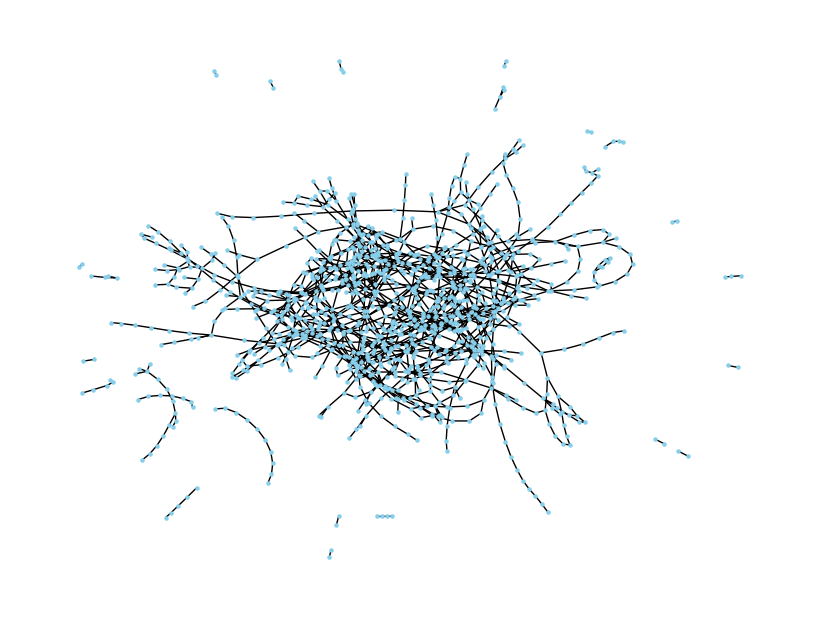

In [7]:
# Print the network using networksX package
G = nx.Graph()

G.add_edges_from(edge_list)

plt.figure(figsize=(8, 6))
# Draw the graph
nx.draw(G, node_color='skyblue', node_size=5, edge_color='black')

## ASSIGNMENT 2: Compute the direct and cumulative degree distribution, the average nn degree and the clustering 

In [27]:
'''Functions needed'''

# Devolves an array containing the node 'j' nearest neighbours
@njit
def select_nn(FN, K,  j):
        return FN[ sum(K[:j]) : sum(K[:j]) + K[j] ]

# Find the coincidences between two arrays. Made for seeing how many NN two
# nodes have in common. However, it may not give good results if the network contains
# self-loops. In that case, those must be pruned beforehand
@njit
def intersect(arr1, arr2):
    unique_elements1 = set(arr1)
    unique_elements2 = set(arr2)
    
    # Intersect the two sets and count the common elements
    common_elements = unique_elements1.intersection(unique_elements2)
    
    return len(common_elements)

# Find how many triangles are there in the network
@njit
def find_triangles(K, FN, nodes):
    ''' 
    Triangles: List of triangles per node 
    '''

    triangles = np.zeros(nodes)

    for i in range(nodes):
        num=0
        aux = select_nn(FN, K, i)

        for j in range(int(K[i])):
            com_aux = select_nn(FN, K, aux[j])
            num += intersect(aux, com_aux)

        triangles[i]= num/2

    return triangles

@njit
def clustering_per_degree(K, nodes, PDF, triangles ):
    ''' 
    
    Clustering: Clustering per degree.
    Degree list starts on 0 end in max(K)
    Mean clustering: average network clustering coefficient.

    '''
    max_degree = int(max(K))+1
    clustering = np.zeros(max_degree)
    mean_clust = 0

    for i in range(nodes):
        aux = 0
        ki = int(K[i])

        if ki > 1:
            ti = triangles[i]
            aux += 2* ti / (ki * (ki - 1)*PDF[ki])
            mean_clust += 2* ti / (ki * (ki - 1))
        # Compute the clustering for the node i and store it in the 
        # total clustering of the nodes of its class
        clustering[ki] += aux
    mean_clust /= nodes
    return clustering, mean_clust


@njit
def avnn_per_degree(K, FN,nodes,PDF):
    ''' 
    
    Results: Av NN per degree.
    Degree list starts on 0 end in max(K)
    
    '''
    max_degree = int(max(K))+1
    avnn = np.zeros(max_degree)
    results = np.zeros(max_degree)

    for i in range(nodes):

        index = int(K[i])
        aux = 0
        aux_array = select_nn(FN, K, i) 
        for j in range(int(K[i])):
            aux += K[aux_array[j]] 
        aux /= (K[i] )

        avnn[index] += aux

    # normalization by the total number of nodes in the degree class
    results = avnn/PDF
    
    return np.nan_to_num(results, nan=0.0)


def degree_distribution(K, nodes):
    ''' 
    
    pdf: degree distribution
    PDF: normalized degree distribution
    CDF: cummulative degree distribution
    Degree list starts on 0 end in max(K)
    
    '''
    max_degree = int(max(K))+1
    pdf = np.zeros(max_degree)
    CDF = np.zeros(max_degree)

    for d in K:
        pdf[int(d)] += 1
    PDF = pdf/nodes

    suma = 0
    
    for i in range(len(PDF)):
        suma += PDF[i]
        CDF[i] = 1 - suma
    
    return PDF , CDF, pdf

def print_cdf_pdf(K, PDF, CDF, log):

    # PDF: P(k)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(range(0,int(max(K))+1), PDF,  linestyle='-')
    aux_mean = np.round(np.average(K),3)
    if log==True:
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    ax1.set_xlabel('k', fontsize=14)
    ax1.set_ylabel('P(k)', fontsize=14)
    ax1.set_title('Degree distribution', fontsize=16, fontweight = 'bold')
    ax1.axvline(x=np.average(K), color='r', linestyle='--', label=f'$<k> = {aux_mean}$')
    ax1.legend()
    
    fig.subplots_adjust(wspace=0.6)
    
    # Plot the CDF: CCCP(k)
    ax2.plot(range(0,int(max(K))+1), CDF, linestyle='-')
    if log==True:
        ax2.set_xscale('log')
        ax2.set_yscale('log')
    ax2.set_xlabel('k', fontsize=14)
    ax2.set_ylabel('CCCP(k)', fontsize=14)
    ax2.set_title('Cumulative degree distribution', fontsize=16, fontweight = 'bold')
    plt.tight_layout()
    
def print_clustering_avnn(K, clustering, avnn, PDF, log, mean):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    list = np.arange(0, int(max(K))+1)
    ax1.plot(list   , clustering  )
    if log==True:
        ax1.set_xscale('log')
        ax2.set_yscale('log')
    ax1.set_xlabel('k', fontsize=14)
    ax1.set_ylabel(r'$\bar{C}_k$', fontsize=14)
    ax1.set_title('Clustering coefficient', fontsize=16, fontweight = 'bold')
    ax1.axhline(y=2*mean, color='r', linestyle='--', label=r'$<\bar{c}(k)> = $' + f'${np.round(mean,4)}$')
    ax1.legend()

    # Normalization factor
    fig.subplots_adjust(wspace=0.6)
    k_av = 0
    k_av_cuad= 0
    for k, p in enumerate(PDF):
        k_av += k*p
        k_av_cuad += k*k*p

    ax2.plot(list, avnn*k_av / k_av_cuad)
    if log==True:
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    ax2.set_xlabel('k', fontsize=14)
    ax2.set_ylabel(r'$\bar{k}_{nn}\;\frac{<k>}{<k^2>}$', fontsize=14)
    ax2.set_title('Average nearest neighbor degree', fontsize=16, fontweight = 'bold')
    plt.tight_layout()

In [9]:
PDF, CDF, pdf_not_normalized =degree_distribution(K, total_nodes)
triangles = find_triangles(K, FN, total_nodes)
clustering_node, mean = clustering_per_degree(K, total_nodes, pdf_not_normalized, triangles)
avnn_node = avnn_per_degree(K,FN, total_nodes,  pdf_not_normalized)

Total number of triangles:  32.0


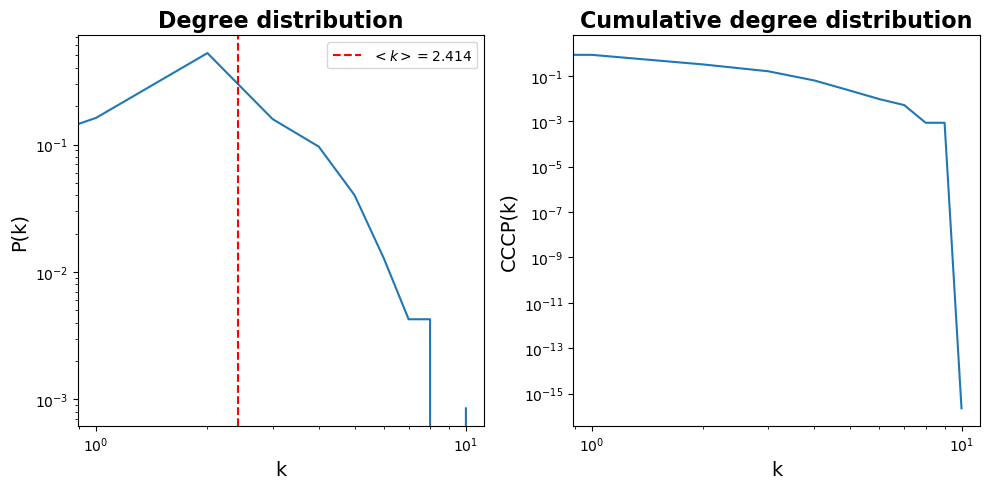

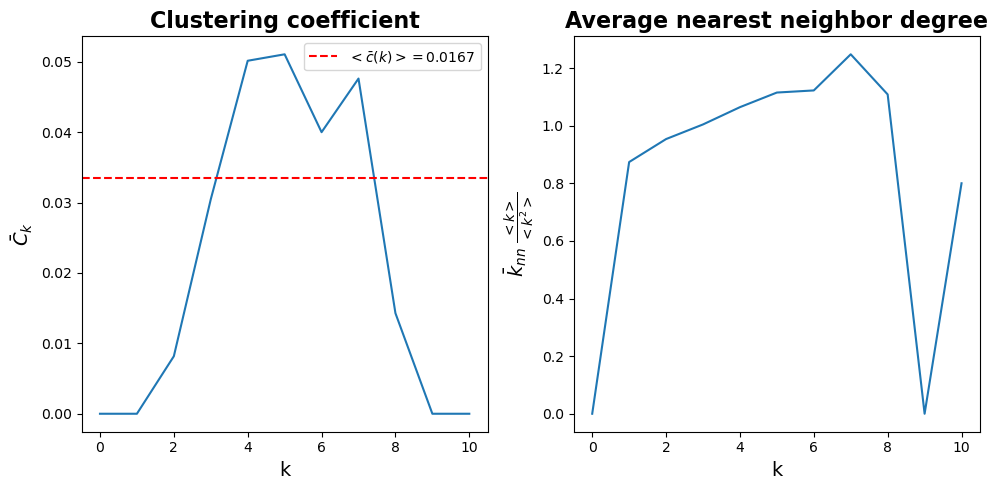

In [28]:
print('Total number of triangles: ', np.sum(triangles)/3)
print_cdf_pdf(K, PDF, CDF, True)
print_clustering_avnn(K, clustering_node, avnn_node, PDF, False, mean)

## ASSIGNMENT 3: Make a CM random network and compute its topological properties

Configuration model algorithm: the steps of the algorithm are explained. 

    Validation of Degree Sequence:
        The function first checks if the sum of the degrees is even. If the sum is odd, the function raises a ValueError since a valid degree sequence must have an even sum.

    Stub List Creation:
        A list of nodes is created where each node appears as many times as its degree. This is achieved by iterating over the degree_sequence and extending the stub_list accordingly.

    Edge Creation:
        An empty list edges is initialized to store the edges of the graph.
        The stub_list is shuffled randomly to ensure random connections between nodes.
        Nodes are then paired from the stub_list to form edges. If a loop (an edge from a node to itself) is encountered, it is discarded and the nodes are shuffled again.

    Loop and Disconnected Stub Handling:
        The function continues linking nodes until the stub_list is empty or contains only one node (which would mean an odd number of nodes, hence retrying the generation process).

    Returning the Edges:
        Once all nodes are properly linked without loops or remaining stubs, the list of edges is returned.

This algorithm rewires the network keeping the same degree list but alters the nearest neighbors, creating a random graph.

In [11]:
'''Functions needed'''

# Rewiring function


def generate_configuration_model(degree_sequence):
    while True:
        # Verifying if the sequence of degrees is valid
        if np.sum(degree_sequence) % 2 != 0:
            raise ValueError("The sum of the degrees must be even")

        # List of nodes replicated by their degrees
        stub_list = []
        for node, degree in enumerate(degree_sequence):
            stub_list.extend([node] * degree)

        # List of edges
        edges = []

        # Random connections
        random.shuffle(stub_list)

        # Linking the nodes
        while len(stub_list) > 1:
            u = stub_list.pop()
            v = stub_list.pop()

            if u != v:
                edges.append((u, v))
            else:
                # Neglecting the loops
                stub_list.append(u)
                random.shuffle(stub_list)

        # Verifying if there is no linked nodes
        if len(stub_list) == 1:
            continue  # Retry generating the graph

        return edges

# Repetition of the rewiring plus computing of topological properties
def assignment5(nodes, K, iter, links, pdf):

        # We store the results here
    rewiring_nn = [0]*iter
    rewiring_clustering =  [0]*iter

    base_k = K.copy()
    results_nn = [0]*(int(max(K))+1)
    results_clustering = [0]*(int(max(K))+1)

    for i in range(iter):
        
        # Compute the new edge list
        new_edge_list = generate_configuration_model(base_k)
        
        # Compute FN 
        new_FN = FN_array(nodes, links, new_edge_list,base_k )
        
        # Compute the rest of the stuff
        triangles = find_triangles(base_k, new_FN, nodes)
       
        rewiring_clustering[i], rmean = clustering_per_degree(base_k, nodes, pdf , triangles)
        rewiring_nn[i] = avnn_per_degree(base_k, new_FN, nodes, pdf)
   
    # Do the total averages
    for j in range(int(max(K))+1):
        aux1 = 0
        aux2 = 0
        for s in range(iter):
            aux1 += rewiring_clustering[s][j]/iter
            aux2 += rewiring_nn[s][j]/iter
        results_clustering[j] = aux1
        results_nn[j] =aux2
    
    return results_clustering, results_nn


c:\Users\irene\anaconda3\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'edge_list' of function 'FN_array'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\irene\AppData\Local\Temp\ipykernel_20360\261356335.py", line 41:
@njit
def FN_array(nodes, links, edge_list, K):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


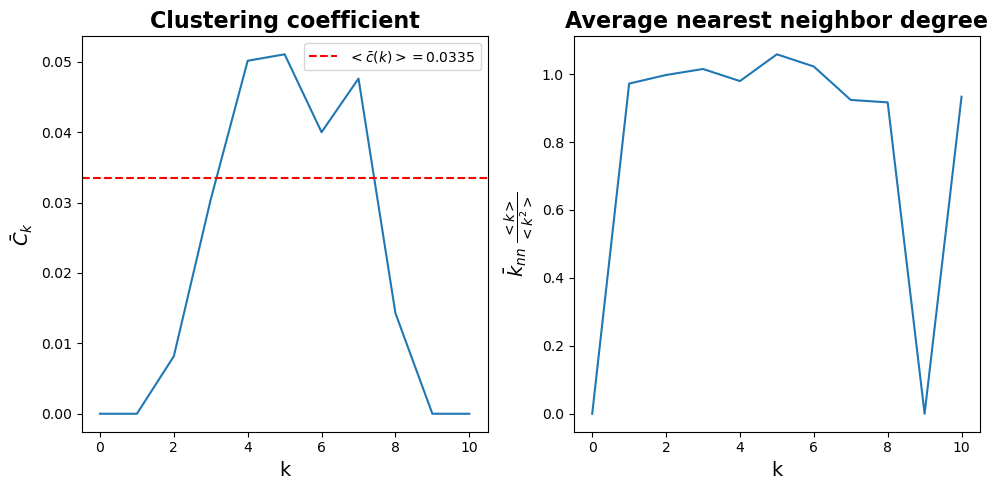

In [12]:
# Generate one new configuration model and compute its topological properties
gene_edges = generate_configuration_model(K)
gene_fn  = FN_array(total_nodes, total_links, gene_edges, K)


gtriangles = find_triangles(K, gene_fn, total_nodes)
gclustering_node, gmean = clustering_per_degree(K, total_nodes, pdf_not_normalized, triangles)
gavnn_node = avnn_per_degree(K,gene_fn, total_nodes,  pdf_not_normalized)
print_clustering_avnn(K, gclustering_node, gavnn_node, PDF, False, gmean)

In [13]:
# Now to 100 repetitions
reps = 100
total_clustering, total_avnn = assignment5(total_nodes, K, reps, total_links, pdf_not_normalized)


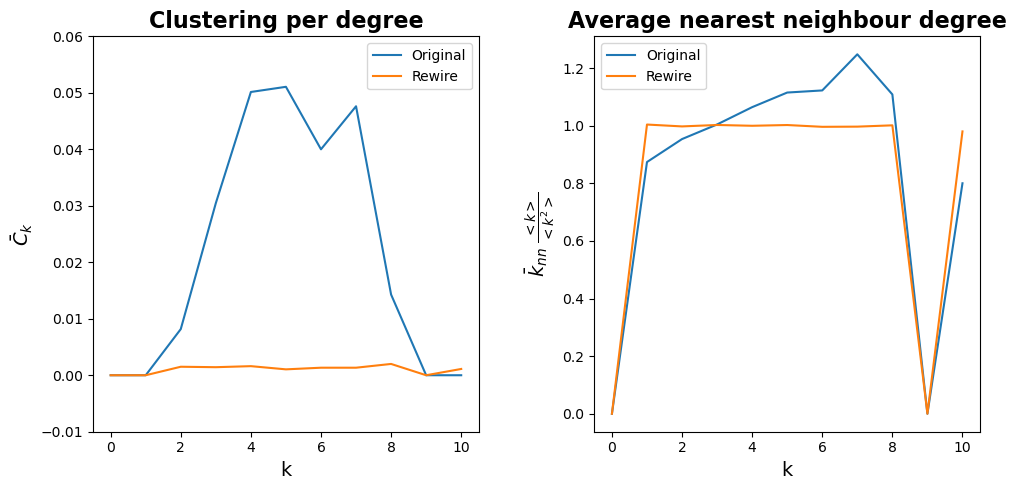

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

list = np.arange(0, int(max(K))+1)
ax1.plot(list   , clustering_node, label='Original'  )
ax1.plot(list   , total_clustering, label='Rewire'  )
ax1.legend()
ax1.set_xlabel('k', fontsize=14)
ax1.set_ylabel(r'$\bar{C}_k$', fontsize=14)
ax1.set_title('Clustering per degree', fontsize=16, fontweight = 'bold')
ax1.set_ylim([-0.01, 0.06])


# Normalization factor
k_av = 0
k_av_cuad= 0
for k, p in enumerate(PDF):
    k_av += k*p
    k_av_cuad += k*k*p

ax2.plot(list, avnn_node*k_av / k_av_cuad, label='Original')
ax2.plot(list, np.asarray(total_avnn)*k_av / k_av_cuad, label='Rewire')
ax2.legend()
ax2.set_xlabel('k', fontsize=14)
ax2.set_ylabel(r'$\bar{k}_{nn}\;\frac{<k>}{<k^2>}$', fontsize=14)
ax2.set_title('Average nearest neighbour degree', fontsize=16, fontweight = 'bold')
plt.tight_layout()
fig.subplots_adjust(wspace=0.3)